In [1]:
import json
import joblib
import pickle
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/train_searched.csv")
df.head()

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,True,False,Bridgeport,10/01/2013 12:46:00 AM,Bridgeport,V,1207,True,I,Speed Related,37.0,H,W,M,True
1,True,True,Milford,10/01/2013 01:50:00 AM,MILFORD,E,2325,True,I,Defective Lights,30.0,N,W,M,True
2,True,False,Torrington,10/01/2013 03:49:00 AM,Torrington,V,DACYR048,True,C,Registration,43.0,N,W,M,True
3,True,False,State Police,10/01/2013 05:30:00 AM,TOLLAND,V,1000002715,False,C,Other,19.0,N,B,M,False
4,True,False,Greenwich,10/01/2013 05:47:00 AM,RIVERSIDE,V,110993,False,N,Speed Related,34.0,M,B,M,False


In [3]:
# lowercaes departments and location names
df['Department Name'] = df['Department Name'].apply(lambda x: str(x).lower())
df['InterventionLocationName'] = df['InterventionLocationName'].apply(lambda x: str(x).lower())

In [4]:
train_features = df.columns.drop(['VehicleSearchedIndicator', 'ContrabandIndicator'])

In [5]:
categorical_features = train_features.drop(['InterventionDateTime', 'SubjectAge'])
numerical_features = ['SubjectAge']

In [6]:
target = 'ContrabandIndicator'

In [7]:
# show the most common feature values for all the categorical features
for feature in categorical_features:
    display(df[feature].value_counts())

Department Name
state police                5449
new haven                   5006
wallingford                 2717
waterbury                   2506
west hartford               2214
                            ... 
mta stamford                   4
mta                            2
wcsu                           1
met dist water authority       1
ecsu                           1
Name: count, Length: 117, dtype: int64

InterventionLocationName
new haven            5719
waterbury            2938
wallingford          2771
norwich              2201
bridgeport           2092
                     ... 
winsted rd.             1
park ave                1
high at turner          1
419                     1
e. elm/brightwood       1
Name: count, Length: 458, dtype: int64

InterventionReasonCode
V    57944
E    13187
I     5612
Name: count, dtype: int64

ReportingOfficerIdentificationID
1000003196    517
1000002072    370
790642042     349
10502         300
30233         299
             ... 
18907           1
JMF0222         1
1000014         1
PSC56047        1
P49             1
Name: count, Length: 4941, dtype: int64

ResidentIndicator
True     70049
False     6694
Name: count, dtype: int64

SearchAuthorizationCode
O    30670
C    27063
I    15710
N     3290
Name: count, dtype: int64

StatuteReason
Other                     11066
Moving Violation           9969
Defective Lights           9127
Speed Related              8332
Registration               7329
Display of Plates          5859
Administrative Offense     4845
Stop Sign                  3738
Traffic Control Signal     3716
Window Tint                3375
Other/Error                2240
Seatbelt                   2173
Cell Phone                 1731
Suspended License          1376
Unlicensed Operation        697
STC Violation               595
Equipment Violation         562
Stop Sign                     3
Name: count, dtype: int64

SubjectEthnicityCode
N    58343
H    17524
M      876
Name: count, dtype: int64

SubjectRaceCode
W    53524
B    22501
A      498
I      220
Name: count, dtype: int64

SubjectSexCode
M    62686
F    14057
Name: count, dtype: int64

TownResidentIndicator
False    46264
True     30479
Name: count, dtype: int64

In [8]:
# I'm going to remove less common features. 
# Let's create a dictionary with the minimum required number of appearences
min_frequency = {
    "Department Name": 50,
    "InterventionLocationName": 50,
    "ReportingOfficerIdentificationID": 30,
    "StatuteReason": 10
}

In [9]:
def filter_values(df: pd.DataFrame, column_name: str, threshold: int):
    value_counts = df[column_name].value_counts()
    to_keep = value_counts[value_counts > threshold].index
    filtered = df[df[column_name].isin(to_keep)]
    return filtered

In [10]:
df.shape

(76743, 15)

In [11]:
for feature, threshold in min_frequency.items():
    df = filter_values(df, feature, threshold)

In [12]:
df.shape

(45334, 15)

In [13]:
X = df[train_features]
y = df[target]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [15]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])

pipeline = make_pipeline(
    preprocessor,
    LGBMClassifier(n_jobs=-1, random_state=42),
)

In [16]:
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 11297, number of negative: 22703
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1866
[LightGBM] [Info] Number of data points in the train set: 34000, number of used features: 933
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.332265 -> initscore=-0.697960
[LightGBM] [Info] Start training from score -0.697960


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Department Name', 'InterventionLocationName', 'InterventionReasonCode',
       'ReportingOfficerIdentificationID', 'ResidentIndicator',
       'SearchAuthorizationCode', 'StatuteReason', 'SubjectEthnicityCode',
       'SubjectRaceCode', 'SubjectSexCode', 'TownResidentIndicator'],
      dtype='object'))])),
                ('lgbmclassifier', LGBMClassifier(n_jobs=-1, random_state=42))])

In [17]:
preds = pipeline.predict(X_test)

In [18]:
def verify_success_rate_above(y_true, y_pred, min_success_rate=0.5):
    """
    Verifies the success rate on a test set is above a provided minimum
    
    
    """
    
    precision = precision_score(y_true, y_pred, pos_label=True)
    is_satisfied = (precision >= min_success_rate)
    
    return is_satisfied, precision


In [19]:
def verify_amount_found(y_true, y_pred):
    """
    Verifies the amout of contraband found in the test dataset - a.k.a the recall in our test set
    """
    
    recall = recall_score(y_true, y_pred)    
    return recall


In [20]:
verify_success_rate_above(y_test, preds)

(True, 0.6681299385425812)

In [21]:
verify_amount_found(y_test, preds)

0.6125570163670513

Now let's find the best threshold for our requirements.

Precision needs to be at least 0.5, and recall has to be as max as possible.

It's usually true that the bigger is precision, the lower is the recall. 

So we need to find the threshold that coresponds to precision = 0.5

In [22]:
proba = pipeline.predict_proba(X_test)

In [23]:
precision, recall, thresholds = precision_recall_curve(y_test, proba[:, 1])

In [25]:
print(len(precision), len(recall), len(thresholds))

6713 6713 6712


In [26]:
# according to documentation, precision and recall
# have 1 and 0 at the end, so we should remove them before plotting.
precision = precision[:-1]
recall = recall[:-1]

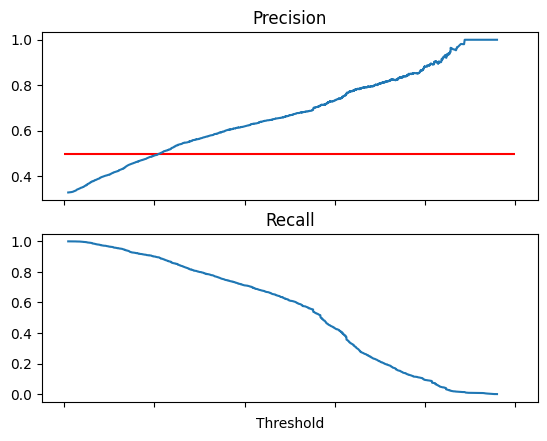

In [28]:
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.sharex(ax2)
ax1.set_xticklabels([])
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.xlabel('Threshold')
plt.show()

Red line shows the point where precision is equal 0.5. 

It looks like the biggest recall for precision >= 0.5 is around 0.2

Let's find the exact value.

In [29]:
min_index = [i for i, prec in enumerate(precision) if prec >= 0.5][0]
print(min_index)

2668


In [30]:
precision[min_index]

0.5

In [31]:
recall[min_index]

0.8932116984169574

In [32]:
thresholds[min_index]

0.21073452797732833

In [33]:
best_preds = [1 if pred > thresholds[min_index] else 0 for pred in proba[:, 1]]

In [34]:
verify_success_rate_above(y_test, best_preds)

(True, 0.5000751089079165)

In [35]:
verify_amount_found(y_test, best_preds)

0.8932116984169574

In [36]:
with open('columns.json', 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)
    
with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)
    
joblib.dump(pipeline, 'pipeline.pickle');